In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt


import sys
sys.path.append("../../../")

from src.difsched.agents.DiffusionQL.DQL_Q_esmb import DQL_Q_esmb as Agent
from src.difsched.utils.DataSampler import ReplayBuffer
from toy_gaussian_helper import create_toy_gaussian_dataset, eval

In [7]:

hyperparams = {
    'N_diffusion_steps': 10,
    'schedule_type': "vp",
    'approximate_action': True,
    'gamma': 0.99,
    'abs_action_max': 1.0,
    'lr': 6e-4,
    'decay_lr': False,
    'weight_decay': 0.001,
    'num_critics': 4,
    'lcb_coef': 0.1,
    'max_q_backup': True,
    'weight_entropy_loss': 0.01,
    'weight_q_loss': 1.0,
    'ema_tau': 0.005,
    'ema_period': 20,
    'ema_begin_update': 1000,
    'device': "cuda",
}

rb_capacity =5000
dataset = create_toy_gaussian_dataset(N_samples=rb_capacity)

data_sampler = ReplayBuffer(capacity=rb_capacity, device=hyperparams['device'])
data_sampler.add(dataset)

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, Ld: 1.0009971730709075, Lq: 3.117336953065824, Le: -0.8209552782177925, loss_Q: 1.6560738487243651


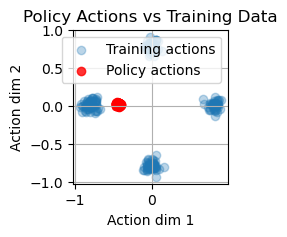

Iteration 1, Ld: 0.7633931345045567, Lq: 2.5504048759937286, Le: -0.8290894226431846, loss_Q: 0.5647420222163201


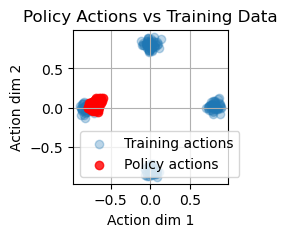

In [ ]:
agent = Agent(state_dim=1, action_dim=2, **hyperparams)

iterations = 1000
batch_size = 100
N_episodes = 4
for i in range(N_episodes):
    metrics = agent.train(data_sampler, iterations, batch_size, tqdm_pos=0)
    print(f"Iteration {i}, Ld: {np.mean(metrics['Ld'])}, " + 
          f"Lq: {np.mean(metrics['Lq'])}, " + 
          f"Le: {np.mean(metrics['Le'])}, " + 
          f"loss_Q: {np.mean(metrics['loss_Q'])}")
    eval(agent, sample_method="EAS", N_eval=200, N_sample=10, eta=0.01, figsize=(2, 2))
    agent.save_model(f"Results", i)

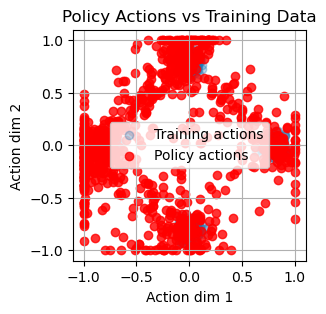

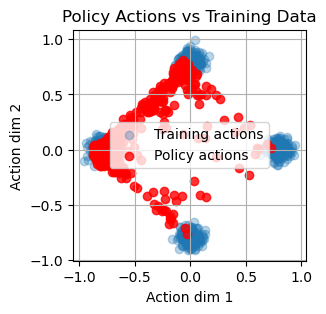

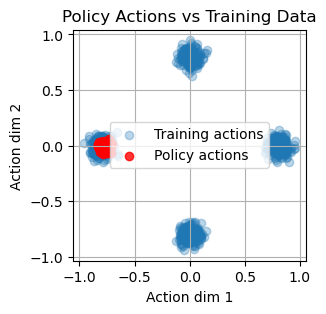

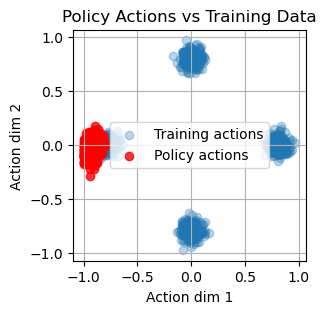

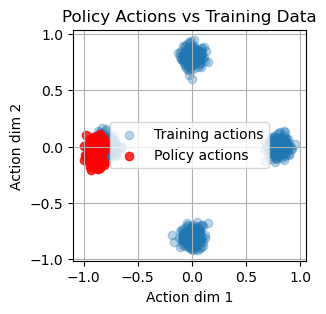

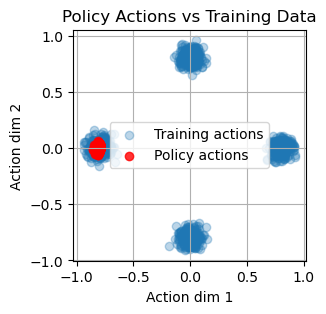

: 

In [ ]:
EAS_data = {'train_01':[], 'train_02':[], 'train_03':[], 'eval_01':[], 'eval_02':[], 'eval_03':[]}
EAS_data['train_01'], EAS_data['eval_01'] = eval(agent, N_eval=1000, sample_method="EAS", N_sample=20, eta=5.0, figsize=(3, 3))
EAS_data['train_02'], EAS_data['eval_02'] = eval(agent, N_eval=1000, sample_method="EAS", N_sample=20, eta=0.2, figsize=(3, 3))
EAS_data['train_03'], EAS_data['eval_03'] = eval(agent, N_eval=1000, sample_method="EAS", N_sample=20, eta=0.01, figsize=(3, 3))

greedy_data = {'train_01':[], 'train_02':[], 'train_03':[], 'eval_01':[], 'eval_02':[], 'eval_03':[]}
greedy_data['train_01'], greedy_data['eval_01'] = eval(agent, N_eval=1000, sample_method="greedy", N_sample=20, eta=1.5, figsize=(3, 3))
greedy_data['train_02'], greedy_data['eval_02'] = eval(agent, N_eval=1000, sample_method="greedy", N_sample=20, eta=0.5, figsize=(3, 3))
greedy_data['train_03'], greedy_data['eval_03'] = eval(agent, N_eval=1000, sample_method="greedy", N_sample=20, eta=0.01, figsize=(3, 3))


import pickle
with open('Results/mix_gaussian/EAS_data.pkl', 'wb') as f:
    pickle.dump(EAS_data, f)

with open('Results/mix_gaussian/greedy_data.pkl', 'wb') as f:
    pickle.dump(greedy_data, f) 

torch.Size([1000, 1])


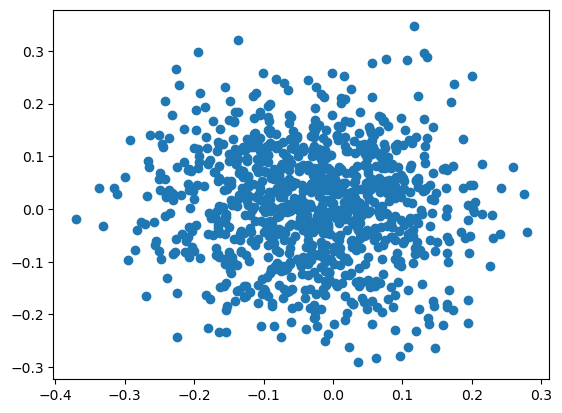

In [5]:
import torch

s = torch.zeros(1000,1).to("cuda")
print(s.shape)


a = agent.actor.sample_DDIM(s, eta=0.1).cpu().detach().numpy()

a = np.array(a)
plt.plot(a[:,0], a[:,1], 'o')



In [6]:
import torch

eta = 1.5
B = 1000
a = torch.randn(B, 2, device="cuda") * (1-agent.actor.schedule.alpha_bar[-1]).sqrt()
noises = torch.randn(agent.actor.schedule.N, B, 2, device="cuda")
for step in reversed(range(1, agent.actor.schedule.N + 1)):
    alpha = agent.actor.schedule.alpha_bar[step - 1]
    alpha_prev = agent.actor.schedule.alpha_bar[step-2] if step > 1 else torch.tensor(1.0, device=s.device)

    t = torch.full((B,), step, device="cuda", dtype=torch.long)
    eps = agent.actor(a, s, t)

    sigma_t = eta * ((1 - alpha_prev) / (1 - alpha)).sqrt() * (1 - alpha/alpha_prev).sqrt()
    x0_pred = alpha_prev.sqrt() * (a - (1-alpha).sqrt() * eps) / alpha.sqrt()
    direct_point_x = (1 - alpha_prev - sigma_t.pow(2)).clamp(0.0).sqrt() * eps
    noise_term = sigma_t * noises[step - 1]
    a = x0_pred + direct_point_x + noise_term
    print(sigma_t.cpu().detach().numpy(), direct_point_x.cpu().detach().numpy()[0], eps.cpu().detach().numpy()[0])

0.42062655 [ 0.02625826 -0.0005118 ] [ 0.06051061 -0.00117941]
0.39644408 [ 0.0310708  -0.00555102] [ 0.08003395 -0.01429863]
0.37066767 [0.02853945 0.00405726] [0.08426238 0.01197901]
0.34297726 [0.02653263 0.01222441] [0.09296759 0.04283306]
0.31291392 [0.02031707 0.00673254] [0.08903738 0.02950463]
0.2797802 [0.01189357 0.00316555] [0.07148892 0.01902723]
0.24240865 [0.00596212 0.0024791 ] [0.06179027 0.02569296]
0.1985215 [0. 0.] [0.06263322 0.01673029]
0.14204006 [0. 0.] [0.0562565  0.04092178]
0.0 [0. 0.] [0.05004746 0.06627477]


In [7]:
from DiffusionQL.Helpers import DiffusionSchedule 

schedule = DiffusionSchedule(N=20, schedule_type="cosine", s=0.0)
#plt.plot(schedule.alpha_bar)

schedule = DiffusionSchedule(N=20, schedule_type="vp", beta_min=0.01, beta_max=2.0)
plt.plot(schedule.alpha_bar)
plt.show()





TypeError: __init__() got an unexpected keyword argument 's'